## Anime with StyleGAN

![hesder](https://pbs.twimg.com/media/D42jr1bUEAAzlGe.jpg)

## Introduction
This work is especially inspired by the research paper [Adversarial Latent Autoencoders](https://arxiv.org/pdf/2004.04467.pdf). What I tried was to build a similar model as explained in this research paper but, I could only bring up only some part of it. To be truthful the model I have build in this notebook is a modified version of the original Adversarial Latent Autoencoder. The code for Adversarial Latent Autoencoders is also explained in PyTorch by the original authors. I know how to deploy a deep learning program in PyTorch but in my current state I am not much fluent in constructing GAN with PyTorch, so in this notebook, I tried to decode the original code with TensorFlow. Even if I would have known how to implement GAN in PyTorch, the code written and explained by the original authors was so difficult to understand that.....<br>

## What is a Autoencoder?
Autoencoder is a network that use unsupervised approaches aiming at combining generative and representational properties by learning simulteniously an encoder-generator map.
## What is ALAE?
ALAE introduces an Autoencoder architecture that is general, and has generative power comparable to GANs while learning a less entangled representation. It basically works on the latent space rathan autoencoding the entire data-space.
![ALAE](https://miro.medium.com/max/1400/1*RDcDG8G3p6StcNAlc9AYpw.png)
<br>
A more detailed analysis and explaination of ALAE cound be found in the link given below:<br>
* [Original research paper](https://arxiv.org/pdf/2004.04467.pdf)
* [Towards Data Science](https://towardsdatascience.com/adversarial-latent-autoencoders-4ce12c0abbdd)

## What is Style ALAE?
StyleALAE uses the StyleGAN based generator along with the Adversarial Latent Autoencoder.StyleALAE can not only generate 1024×1024 face images with comparable quality of StyleGAN, but at the same resolution can also produce face reconstructions and manipulations based on real im-ages.  This makes ALAE the first autoencoder able to compare with,  and go beyond the capabilities of a generator-only type of architecture.
![style alae](https://miro.medium.com/max/1400/1*N6z6OKYf3S3NVbwf7pR4LQ.png)

## Implementation

In this project, I have used usual 256x256 anime faces, instead of using 1204x1024 HD celebrity/human faces. First of all, it needs a lot of computation power and time to iterate over such high-resolution images, and secondly, I decided to choose a new theme fo this project which is not discussed in the research paper, so I chose anime faces over human faces.<br>
And actually, the task was not so easy as I thought. while blending anime faces, generating the lip part in the generated anime face was the most difficult part, not only that coordinating the eyes in the generated face was also a tedious job. It involved a proper selection of data and hyperparameter tuning. A slight change in adjustment of learning rate or epsilon of Adam optimizer changed the entire quality of the generated image.

![funny1](https://i0.wp.com/drunkenanimeblog.com/wp-content/uploads/2019/07/Demon-Slayer-Ep14-24.png?fit=1600%2C900&ssl=1)

In [ ]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip install tensorflow-addons
!pip install --upgrade --ignore-installed tensorflow

/bin/bash: /opt/conda/bin/python3.7: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 1.1 MB 54.0 MB/s 
     |████████████████████████████████| 14.5 MB 44.6 MB/s 
     |████████████████████████████████| 438 kB 59.5 MB/s 
     |████████████████████████████████| 5.8 MB 44.4 MB/s 
     |████████████████████████████████| 4.4 MB 41.9 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 40 kB 6.6 MB/s 
     |████████████████████████████████| 2.4 MB 65.6 MB/s 
     |████████████████████████████████| 15.7 MB 53.3 MB/s 
     |████████████████████████████████| 1.2 MB 67.0 MB/s 
     |████████████████████████████████| 1.6 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import logging

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import random
import sys

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
logging.disable(sys.maxsize)

In [ ]:
BUFFER_SIZE = 10
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
EPOCHS = 2500
LAMBDA = 10
GAMMA = 10
noise_dim = 100

In [ ]:
train_selfie_path = '/input'

In [ ]:
train_selfie_imgs = np.array(sorted(os.listdir(train_selfie_path)))

In [ ]:
train_selfie1_imgs = list(train_selfie_imgs[[0,52,19,54,39,71]])
train_selfie2_imgs = list(train_selfie_imgs[[4,43,55,45,31,23]])

In [ ]:
ImageSet_1 = [(train_selfie_path)+'/%s'%(x) for x in train_selfie1_imgs]
ImageSet_2 = [(train_selfie_path)+'/%s'%(x) for x in train_selfie2_imgs]

In [ ]:
#converting image_file path to tensors
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    image_ = tf.cast(image, tf.float32)
    return image_

In [ ]:
#resize image to height, width
def resize(input_, height, width):
    img_ = tf.image.resize(input_, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)    
    return img_

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_):
    image = tf.cast(input_, tf.float32)
    img_ = (image / 127.5) - 1
   
    return img_

In [ ]:
#randomize image direction
@tf.function()
def random_jitter(input_):
    img_ = resize(input_,IMG_HEIGHT, IMG_WIDTH)

    if tf.random.uniform(()) > 0.5:
        img_ = tf.image.flip_left_right(img_)

    return img_

In [ ]:
#function for loading image including everything
def load_image_train(file_):
    input_ = load(file_)
    img_ = random_jitter(input_)
    img_ = normalize(img_)

    return img_

In [ ]:
train_source = (
    tf.data.Dataset
    .from_tensor_slices((ImageSet_1))
    .map(load_image_train, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(BATCH_SIZE)
)
train_dest = (
    tf.data.Dataset
    .from_tensor_slices((ImageSet_2))
    .map(load_image_train, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(BATCH_SIZE)
)

In [ ]:
#generate noise for the gan fake image generator
def noise_(num, filter, noise):
    noise_layer = tf.keras.layers.Dense(num*num*filter)(noise)
    #noise_layer = tfa.layers.InstanceNormalization()(noise_layer)
    #noise_layer = tf.keras.layers.ReLU()(noise_layer)

    reshape_noise = tf.keras.layers.Reshape((num, num, filter))(noise_layer)

    return reshape_noise

In [ ]:
def downsample(filters, size, stride, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
              tf.keras.layers.Conv2D(
                  filters, 
                  size, 
                  strides=stride, 
                  padding='same',
                  kernel_initializer=initializer, 
                  use_bias=False)
    )
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())#tfa.layers.InstanceNormalization()

    result.add(tf.keras.layers.LeakyReLU(0.4))
    
    return result

In [ ]:
def upsample(filters, size, stride):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    layer = tf.keras.layers.Conv2DTranspose(
            filters, 
            size, 
            strides=stride,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)
    
    result.add(
        layer
    )
    return result

In [ ]:
def Generator():
    input_encoder = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    input_generator = tf.keras.layers.Input(shape=[noise_dim, ])
    initializer = tf.random_normal_initializer(0., 0.02)

    down_stack = [
        #downsample(32, 3, 2, apply_batchnorm=False),
        downsample(64, 3, 2,False),
        downsample(128, 3, 2),
        downsample(256, 3, 2,False),
        downsample(512, 3, 2,),
        downsample(512, 3, 2,False),
        downsample(512, 3, 2,),
     ]
    x = input_encoder
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
  
    skips = reversed(skips[:-1])
    gen_layer = tf.keras.layers.Dense(4*4*512)(input_generator)
    gen_layer = tf.keras.layers.BatchNormalization()(gen_layer)
    gen_layer = tf.keras.layers.LeakyReLU(0.4)(gen_layer)

    reshape = tf.keras.layers.Reshape((4, 4, 512))(gen_layer)
    x = reshape
    up_stack = [
              upsample(512, 3, 2, ),
              upsample(512, 3, 2, ),
              upsample(256, 3, 2, ),
              upsample(128, 3, 2, ),
              upsample(64, 3, 2, ), 
      
   ]

    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') 
    filters = [512,512,256,128,64]
    ndim = [8,16,32,64,128]
    for up, skip, dim, filt in zip(up_stack, skips, ndim, filters):
        x = up(x)
        n = noise_(dim, filt, input_generator)
        x = tf.keras.layers.concatenate([n, x])
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x = tf.keras.layers.concatenate([x, skip])
    
    x = last(x)
    return tf.keras.Model(inputs=[input_encoder,input_generator], outputs=x)

In [ ]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 8192)         827392      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8192)        32768       ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 8192)         0           ['batch_normalization[0][0]']

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    input_ = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    down1 = downsample(64, 3, 2,False)(input_)
    down2 = downsample(128, 3, 2)(down1)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
    conv = tf.keras.layers.Conv2D(256, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv) #Itfa.layers.InstanceNormalization()

    leaky_relu = tf.keras.layers.LeakyReLU(0.4)(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer,
                                )(zero_pad2)
    return tf.keras.Model(inputs=input_, outputs=last)

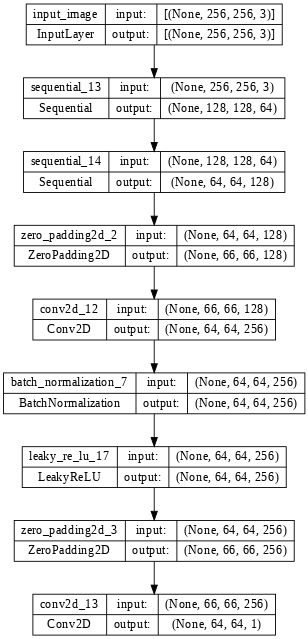

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + (generated_loss)*LAMBDA*0.5
    loss_ = (generated_loss)*LAMBDA*0.5
    
    return total_disc_loss, loss_

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA *(l1_loss)*0.5)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def reconstruction(recon_x, x):
    return tf.reduce_mean(tf.abs(recon_x - x))

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.99,epsilon=1e-08)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.99,epsilon=1e-08)

In [ ]:
def generate_images(model, input_1, input_2, noise):
    prediction = model([input_1, noise], training=True)
    plt.figure(figsize=(15,15))

    display_list = [input_1[0], input_2[0], prediction[0]]
    title = ['Source Image', 'Destination Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y, noise):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([real_x,noise], training=True)

        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, real_y)

        recon_loss = reconstruction(generated_images, real_x)
        disc_loss, _ = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  

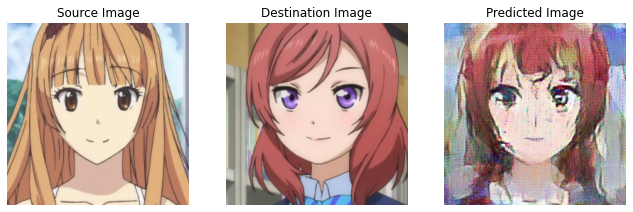

Time taken for epoch 1434 is 12.511574029922485 sec

.

In [ ]:
result=[]
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_source, train_dest)):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        train_step(image_x, image_y, noise)
        if n % 20 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    generate_images(generator, image_x, image_y, noise)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
    if epoch>=2400:
        pred = generator([image_x, noise], training=True)
        result.append(pred[0])

## Source Set

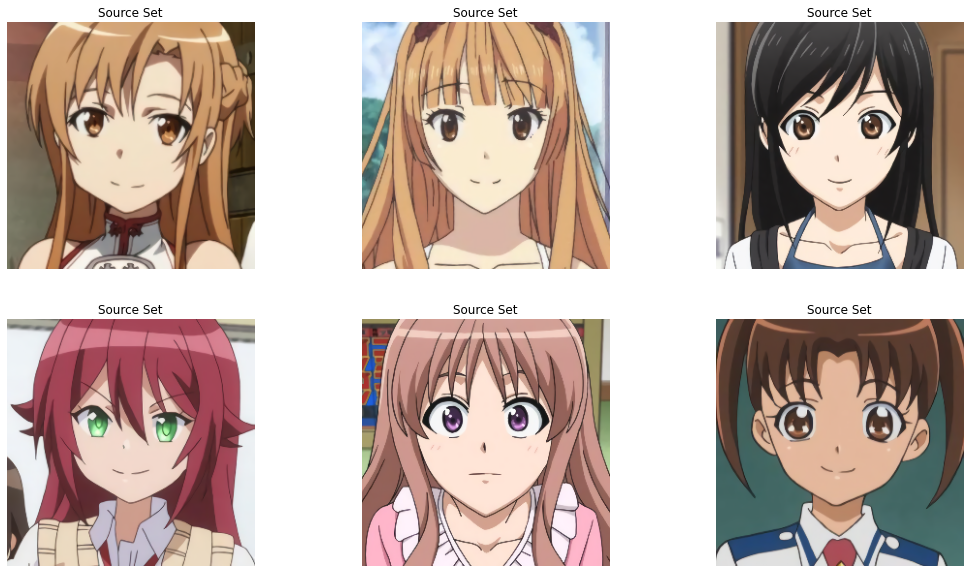

In [ ]:
source = []
dest = []
for x,y in zip(ImageSet_1,ImageSet_2):
    source.append(load_image_train(x))
    dest.append(load_image_train(y))
fig, axis = plt.subplots(2, 3, figsize=(18, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(source[i] * 0.5 + 0.5)
    ax.set(title = f"Source Set")
    ax.axis('off')

## Destination Set

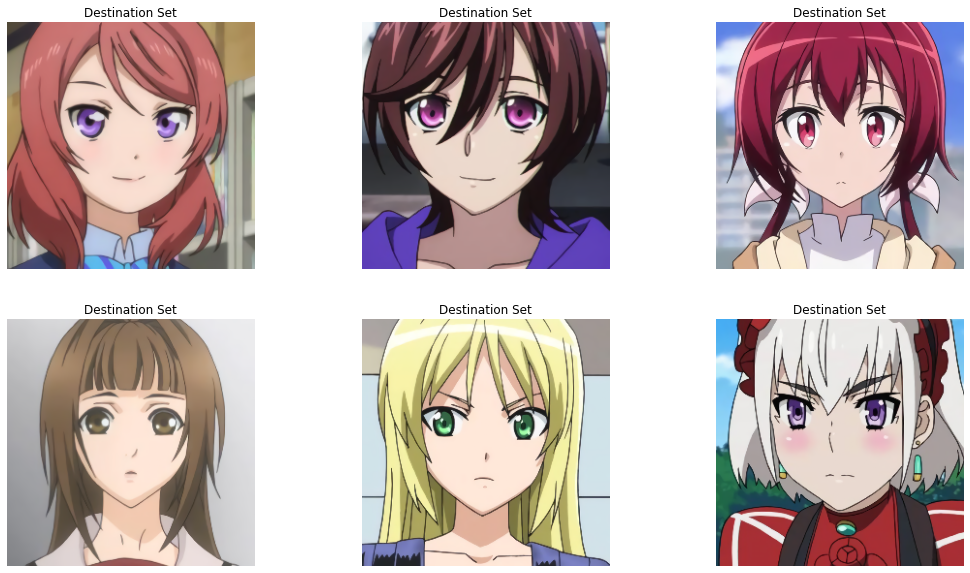

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(18, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(dest[i] * 0.5 + 0.5)
    ax.set(title = f"Destination Set")
    ax.axis('off')

## Generated Images

In [ ]:
res_1 = result[:15]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_1[i] * 0.5 + 0.5)
    ax.axis('off')

In [ ]:
res_2 = result[15:30]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_2[i] * 0.5 + 0.5)
    ax.axis('off')

In [ ]:
res_3 = result[30:45]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_3[i] * 0.5 + 0.5)
    ax.axis('off')

In [ ]:
res_4 = result[45:60]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_4[i] * 0.5 + 0.5)
    ax.axis('off')

In [ ]:
res_5 = result[60:75]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_5[i] * 0.5 + 0.5)
    ax.axis('off')

In [ ]:
res_6 = result[75:90]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_6[i] * 0.5 + 0.5)
    ax.axis('off')

In [ ]:
res_7 = result[90:100]
fig, axis = plt.subplots(2, 5, figsize=(18, 8))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_7[i] * 0.5 + 0.5)
    ax.axis('off')